# Testing the piecewise motion correction  (with miniscope images and artificial shifts)

The piecewise motion correction  is a Python 3.0 implementation of the NormCorre alogrithm (Pnevmatikakis et al. 2017). It has been optimized for the MiniScope (Cai et al., 2016), a portable microscope for calcium imaging in freely moving animals.
G : correction with miniscope images and artificial shifts).


In order to test this piecewise motion correction, we will take the first image of a miniscope recording as a **template** and we will shift a 100 by 100 pixels area surrounding the maximum of fluorescence in this template in order to get the **shifted image**. Then we will divided the **shifted image** and the **template** into patchs of 36 by 36 pixels with overlaps of 6 by 6 pixels between them. For each patch a displacement vector will be calculated by comparing the **shifted image** to the **template**  and then will be plot in order to get a vector field of the displacement vectors on the **shifted image**. Each displacement vector is then applied to the corresponding patch in order to correct the inital shift. The corrected patchs will then be join in order to get the **corrected image**.

**Here x correspond the the height, and y correspond the the weight**. 

## Basic imports


In [3]:
import numpy as np
import scipy
import yaml
import sys,os
import h5py as hd
from time import time
import av
import glob
import itertools
from scipy import interpolate
from scipy import signal
import pandas as pd
import re
from tqdm import tqdm
from IPython.core.debugger import Pdb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from copy import copy
from miniscopy.base.sima_functions import *
from miniscopy.base.motion_correction import *
from miniscopy import setup_cluster, CNMFE
from miniscopy import Movie

## Load the inital movie and the parameters

Here we details the beginning of miniscopy. You should first load the movies from miniscop recording, convert it to and HDF5 file and load the corresponding parameters. When cloning from Github, the example movie and the parameter file should already be present in /bad_movie.

### Load the movie as an hdf file 

The miniscope recording system usually outputs a set of avi files in one folder. You can give the path of this folder or download an example of a recording movie from the dropbox. We have choosed a video recorded from our miniscope recording experiments.

G : il faut creer un liens vers video badmovie


In [4]:
folder_name = 'bad_movie'
files = glob.glob(folder_name+'/*.avi')
if len(files) == 0:
    import urllib.request
    url = "https://www.dropbox.com/s/0x3twp8bidl9svu/msCam1.avi?dl=1"
    with urllib.request.urlopen(url) as response, open(folder_name+"/msCam1.avi", 'wb') as out_file:
        data = response.read()
        out_file.write(data)
    files = glob.glob(folder_name+'/*.avi')
    if len(files) == 0: print("No avi files found, please provide one at least")

print(files)
video_info, videos, dims = get_video_info(files)
print(files)
print(video_info)


['bad_movie/A0609_msCam1.avi']
['bad_movie/A0609_msCam1.avi']
                             start   end duration
  file_name                                      
0 bad_movie/A0609_msCam1.avi     0  1000     1000


Then the .avi files are convert to a HDF5 file (The HDF Group. Hierarchical Data Format, version 5, 1997-2018. http://www.hdfgroup.org/HDF5/). Wich is a container files format that simplifies the storage and managing of large amounts of data, in particular by attaching attributes (i.e. extra information) to every dataset or group it contains.  

In [5]:
try:
    hdf_mov = get_hdf_file(videos, video_info, dims)
except:
    pass

print(hdf_mov)


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

<HDF5 file "motion_corrected.hdf5" (mode r+)>


### Load the parameters 

In [6]:
parameters = yaml.load(open(folder_name+'/parameters.yaml', 'r'))
parameters_glob = yaml.load(open('bad_movie/parameters.yaml', 'r'))
parameters = parameters_glob['motion_correction']


# 1. Create the template and the shifted image 
Here we will start testing of the piecwise motion correction. You should first load the first image of the movie download above. This image will be use as a template for the piecwise motion correction. Then you can detect the most fluorescent part of this template and shift a 100 by 100 pixels area to simulate brain moving under the camera above the recorded region of the brain.

### 1.1 Initialize the shift 
Here we initialize the shift that will be applied to the **template** image in order to get the **shifted image**. In this example we took a 3 pixels shit to the left.
(N.B : a positive vertical shift brings the cropped area towards the top).

In [7]:
shift_appli = [0,3] #shift in direction  (-h,-w)

### 1.2  Extract the first image of the movie 
The first image of the movie will be the template.

In [8]:
movie = hdf_mov['movie']
template1 = movie[0].copy()
template = template1.reshape(dims)


### 1.3 Create the shifted image

We will take the first image of the movie as a template and we simulate a local deformation by shifting all the pixels around an area of fluoresence . 
We take the future shifted area as a 100 by 100 pixels square around the maximum of fluorescence of the template.

#### 1.3.1 Get the maximum of fluorescence of the template and determine the area that will be shifted 

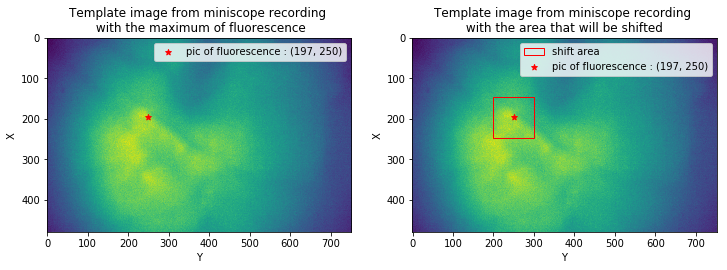

In [49]:
max_fluo_template, mf_template = get_max_fluo(template,parameters)

top,bottom, left, right = max_fluo_template[0]-50,max_fluo_template[0]+50,max_fluo_template[1]-50,max_fluo_template[1]+50
rect = patches.Rectangle((left,top),100,100,linewidth=1,edgecolor='r',facecolor='none',label = 'shift area')


fig1, (ax1,ax2) = plt.subplots(1,2, figsize=(12,12))
ax1.imshow(template)
ax1.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_template))
ax1.set_title('Template image from miniscope recording \n with the maximum of fluorescence')
ax1.set_xlabel('Y')
ax1.set_ylabel('X')
ax1.legend(loc='best')

ax2.imshow(template)
ax2.add_patch(copy(rect))
ax2.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_template))
ax2.set_title('Template image from miniscope recording \n with the area that will be shifted ')
ax2.set_xlabel('Y')
ax2.set_ylabel('X')
ax2.legend(loc='best')

#### 1.3.2 Create the image and get the new pic of fluorescence
 Shift to the left a square of 100 by 100 pixels centered on the maximum of fluorescence of the template.

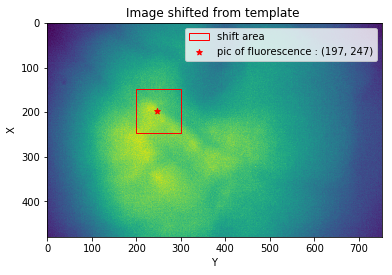

In [12]:
image =  template.copy()
image[top : bottom, left:right] = image[top + shift_appli[0] : bottom + shift_appli[0], left+ shift_appli[1]: right + shift_appli[1]]
max_fluo_image, mf_image = get_max_fluo(image,parameters)

fig3,ax3 = plt.subplots()
ax3.imshow(image)
ax3.add_patch(copy(rect))
ax3.scatter(max_fluo_image[1], max_fluo_image[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_image))
ax3.set_title('Image shifted from template ')
ax3.set_xlabel('Y')
ax3.set_ylabel('X')
ax3.legend(loc='best')

### 1.4 Compare the template with the shifted image

As the shift is not big we can only see the maximum of fluorescence shifted toward the left of the screen through the coordinates of the pic of fluorescence.


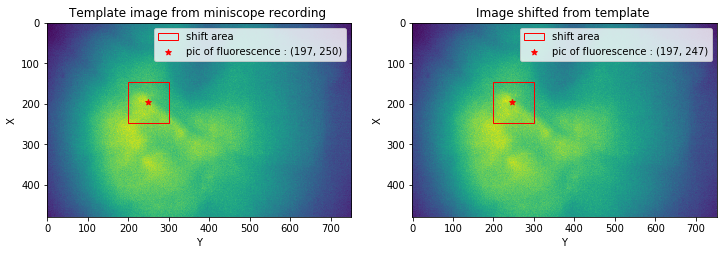

In [13]:

fig,(ax2,ax3) = plt.subplots(1,2, figsize=(12,12))
ax2.imshow(template)
ax2.add_patch(copy(rect))
ax2.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_template))
ax2.set_title('Template image from miniscope recording ')
ax2.set_xlabel('Y')
ax2.set_ylabel('X')
ax2.legend(loc='best')

ax3.imshow(image)
ax3.add_patch(copy(rect))
ax3.scatter(max_fluo_image[1], max_fluo_image[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_image))
ax3.set_title('Image shifted from template ')
ax3.set_xlabel('Y')
ax3.set_ylabel('X')
ax3.legend(loc='best')
plt.show()



# 2. Create a vector field of the displacement vectors

Inspired by normcorre we divided the image into overlapping patches. Then we calculated the displacement vector of each patch by comparing each patch of the template with corresponding patch of the shifted image. 


### 2.1  Divide the image into patches 
First we have to determine the grid of patches and overlaps.

Text(0,0.5,'X')

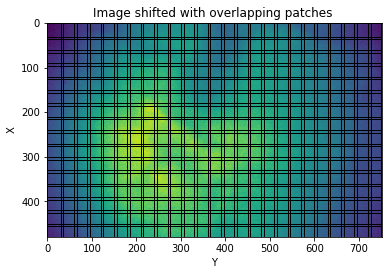

In [48]:
patches_index, wdims, pdims    = get_patches_position(dims, **parameters)
num_patches = pdims[0]*pdims[1]
patch_LIST = []
for i in range (0,num_patches):
    top_patch, left_patch = patches_index[i]
    patch_LIST.append(patches.Rectangle((left_patch,top_patch),wdims[1],wdims[0],linewidth=1,edgecolor='black',facecolor='none'))

fig4,ax4 = plt.subplots()
ax4.imshow(image)
for i in range (0,num_patches):
    ax4.add_patch(patch_LIST[i])
ax4.set_title('Image shifted with overlapping patches ')
ax4.set_xlabel('Y')
ax4.set_ylabel('X')
 




### 2.2 Get the shift for each patches
Then we have to filter the template and the shifted image, in order to compare each patch of the template to the corresponding patch of the shifted image. For each patch we compute the displacement vector that should be applied in order to correct the shift. We then obtain for each vector its x coordinates, which are store in a matrix (here shift_img_x) and its y coordinate, store in another matrix (shift_img_y).

As the shifted image, is shifted of 3 pixels to the left in the area surrounding the pic of fluorescence, we should have an X matrix of 0 and a matrix Y of 0 except in the shifted area were the number should be around 3.


In [39]:
shifts_patch = np.zeros((len(patches_index),2))
for i,patch_pos in enumerate(patches_index):
	xs, xe, ys, ye = (patch_pos[0],np.minimum(patch_pos[0]+wdims[0],dims[0]-1),patch_pos[1],np.minimum(patch_pos[1]+wdims[1],dims[1]-1)) # s = start, e = exit
	filtered_image = low_pass_filter_space(image[xs:xe,ys:ye].copy(), parameters['filter_size_patch'])
	filtered_template = low_pass_filter_space(template[xs:xe,ys:ye].copy(), parameters['filter_size_patch'])
	shifts_patch[i], error, phasediff = register_translation(filtered_template, filtered_image, parameters['upsample_factor'],"real",None,None, parameters['max_shifts']) #coordinate given back in order Y,X
  
shift_img_x = shifts_patch[:,0].reshape(pdims)
shift_img_y = shifts_patch[:,1].reshape(pdims) 



### 2.3  Upsampling (optional)
In order to be more precise we can subdivide the grid in order to have more patches to shift. You should change **parameters['upsample_factor_grid']** in order to determine the factor by which you want to multiple the number of patches.

In [43]:
# upsampling 
new_overlaps    = parameters['overlaps']
new_strides     = tuple(np.round(np.divide(parameters['strides'], parameters['upsample_factor_grid'])).astype(np.int))
upsamp_patches_index, upsamp_wdims, upsamp_pdims = get_patches_position(dims, new_strides, new_overlaps)

# resize shifted image
shift_img_x     = cv2.resize(shift_img_x, (upsamp_pdims[1],upsamp_pdims[0]), interpolation = cv2.INTER_CUBIC)
shift_img_y     = cv2.resize(shift_img_y, (upsamp_pdims[1],upsamp_pdims[0]), interpolation = cv2.INTER_CUBIC)



### 2.4 Vizualize the vector field



In [44]:
def vector_field (matrix_X, matrix_Y,strides,wdims,pdims,dims):
    """
    Creat a vector field from matrix of coordinates
    
    parameters : 
    -matrix_X = matrix of height coordinates of the vector field
    -matrix_Y = matrix of weight coordinates of the vector field
    -strides = np.array, (top,left) coordinates of each patch
    -wdims = np.array, dimension of each patch (h,w)
    -dims = dimension of the image
    -pdims = np.array, (number of patches on heigt, number of patches on weight)
    """
    x= np.zeros(pdims[1])
    y= np.zeros(pdims[0])
    for i in range(0,pdims[1]):
        x[i]= np.minimum(strides[1]*i + wdims[1]/2, dims[1])
    for j in range(0,pdims[0]):
        y[j]= np.minimum(strides[0]*j + wdims[0]/2, dims[0])
    X,Y = np.meshgrid(x,y)

    X_flat = np.ravel(X.copy())
    Y_flat = np.ravel(Y.copy())


    U_flat= np.ravel(matrix_Y.copy())
    V_flat = np.ravel(matrix_X.copy())

    xp = np.zeros(U_flat.shape)
    yp = np.zeros(V_flat.shape) 

    xp.fill(np.nan)
    yp.fill(np.nan)

    for i, uf in enumerate(U_flat):
        if uf == 0 and V_flat[i] == 0 :
            U_flat[i] = None
            V_flat[i] = None
            xp[i] = X_flat[i]
            yp[i] = Y_flat[i]

    U = U_flat.reshape(pdims)
    V = V_flat.reshape(pdims)

    Xp = xp.reshape(pdims)
    Yp = yp.reshape(pdims)

    return (X,Y,U,V,Xp,Yp)

In [45]:
X,Y,U,V,Xp,Yp = vector_field(shift_img_x,shift_img_y,new_strides,upsamp_wdims,upsamp_pdims,dims)

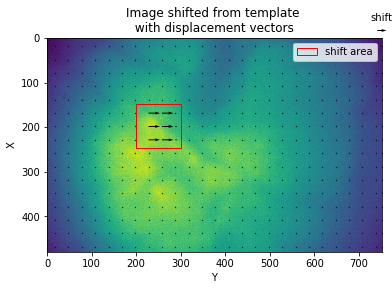

In [50]:
fig5, ax5 = plt.subplots()
ax5.imshow(image)
q = ax5.quiver(X, Y, U, V, angles='xy')
ax5.quiverkey(q, 0.9, 0.9, 2, r'shift', labelpos='N',coordinates='figure')
ax5.scatter(Xp,Yp,marker=".", c ='black', s = 0.5)
ax5.add_patch(copy(rect))
ax5.set_xlim([0, dims[1]])
ax5.set_title('Image shifted from template \n with displacement vectors ')
ax5.set_xlabel('Y')
ax5.set_ylabel('X')
ax5.legend(loc=1)

plt.show()


We will show the results for another example.

In [52]:
def get_vector_field_image (folder_name,shift_appli):
    folder_name = 'bad_movie_2'
    files = glob.glob(folder_name+'/*.avi')
    video_info, videos, dims = get_video_info(files)
    hdf_mov2 = get_hdf_file(videos, video_info, dims)
    parameters = yaml.load(open(folder_name+'/parameters.yaml', 'r'))
    parameters_glob = yaml.load(open('bad_movie/parameters.yaml', 'r'))
    parameters = parameters_glob['motion_correction']
    movie = hdf_mov2['movie']
    template1 = movie[0].copy()
    template = template1.reshape(dims)
    max_fluo_template, mf_template = get_max_fluo(template,parameters)
    top,bottom, left, right = max_fluo_template[0]-50,max_fluo_template[0]+50,max_fluo_template[1]-50,max_fluo_template[1]+50
    rect = patches.Rectangle((left,top),100,100,linewidth=1,edgecolor='r',facecolor='none',label = 'shift area')
    image =  template.copy()
    image[top : bottom, left:right] = image[top + shift_appli[0] : bottom + shift_appli[0], left+ shift_appli[1]: right + shift_appli[1]]
    max_fluo_image, mf_image = get_max_fluo(image,parameters)
    patches_index, wdims, pdims    = get_patches_position(dims, **parameters)
    shifts_patch = np.zeros((len(patches_index),2))
    for i,patch_pos in enumerate(patches_index):
        xs, xe, ys, ye = (patch_pos[0],np.minimum(patch_pos[0]+wdims[0],dims[0]-1),patch_pos[1],np.minimum(patch_pos[1]+wdims[1],dims[1]-1)) # s = start, e = exit
        filtered_image = low_pass_filter_space(image[xs:xe,ys:ye].copy(), parameters['filter_size_patch'])
        filtered_template = low_pass_filter_space(template[xs:xe,ys:ye].copy(), parameters['filter_size_patch'])
        shifts_patch[i], error, phasediff = register_translation(filtered_template, filtered_image, parameters['upsample_factor'],"real",None,None, parameters['max_shifts']) #coordinate given back in order Y,X
    shift_img_x     = shifts_patch[:,0].reshape(pdims)
    shift_img_y     = shifts_patch[:,1].reshape(pdims) 
    new_overlaps    = parameters['overlaps']
    new_strides     = tuple(np.round(np.divide(parameters['strides'], parameters['upsample_factor_grid'])).astype(np.int))
    upsamp_patches_index, upsamp_wdims, upsamp_pdims = get_patches_position(dims, new_strides, new_overlaps)
    shift_img_x     = cv2.resize(shift_img_x, (upsamp_pdims[1],upsamp_pdims[0]), interpolation = cv2.INTER_CUBIC)
    shift_img_y     = cv2.resize(shift_img_y, (upsamp_pdims[1],upsamp_pdims[0]), interpolation = cv2.INTER_CUBIC)
    X,Y,U,V,Xp,Yp = vector_field(shift_img_x,shift_img_y,new_strides,upsamp_wdims,upsamp_pdims,dims)
    return (image,X, Y, U, V,Xp,Yp,rect,dims)

100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


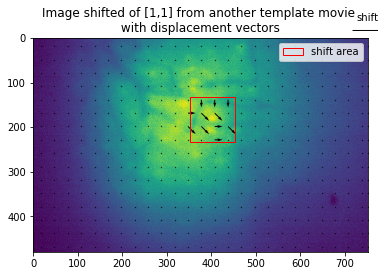

In [53]:
shift_appli = [1,1]
image_2, X_2 , Y_2, U_2, V_2,Xp_2,Yp_2,rect_2,dims_2 = get_vector_field_image('bad_movie_2',shift_appli)

fig6, ax6 = plt.subplots()
ax6.imshow(image_2)
q_2 = ax6.quiver(X_2, Y_2, U_2, V_2, angles='xy')
ax6.quiverkey(q_2, 0.9, 0.9, 2, r'shift', labelpos='N',coordinates='figure')
ax6.scatter(Xp_2,Yp_2,marker=".", c ='black', s = 0.5)
ax6.add_patch(copy(rect_2))
ax6.set_xlim([0, dims_2[1]])
ax6.set_title('Image shifted of [1,1] from another template movie \n with displacement vectors ' )
ax6.legend(loc=1)

plt.show()


## 3. Obtain the corrected image
In order to get the new image, you must shift each patch according to its displacment vector and to gather the new patches together.

### 3.1 Apply shift iteration

In [54]:
num_tiles           = np.prod(upsamp_pdims) #number of patches
max_shear           = np.percentile([np.max(np.abs(np.diff(ssshh, axis=xxsss))) for ssshh, xxsss in itertools.product([shift_img_x, shift_img_y], [0, 1])], 75) #?What is that   
total_shifts        = np.vstack((shift_img_x.flatten(),shift_img_y.flatten())).transpose()
new_upsamp_patches  = np.ones((num_tiles, upsamp_wdims[0], upsamp_wdims[1]))*np.inf
for i, patch_pos in enumerate(upsamp_patches_index):
    if total_shifts[i].sum():#where there is a shift
        xs, xe, ys, ye  = (patch_pos[0],np.minimum(patch_pos[0]+upsamp_wdims[0],dims[0]-1),patch_pos[1],np.minimum(patch_pos[1]+upsamp_wdims[1],dims[1]-1))
        patch           = image[xs:xe,ys:ye]
        new_upsamp_patches[i,0:patch.shape[0],0:patch.shape[1]] = apply_shift_iteration(patch.copy(), total_shifts[i], border_nan = False)



### 3.2 Join the corrected patches together


In [56]:

def join_patches(image,max_shear,upsamp_wdims,new_overlaps,upsamp_pdims,upsamp_patches_index,patch_pos,total_shifts):
    normalizer      = np.zeros_like(image)*np.nan
    new_image = image.copy()

    if max_shear < 0.5:
        np.seterr(divide='ignore')
        # create weight matrix for blending
        # different from original.    
        tmp             = np.ones(upsamp_wdims)    
        tmp[:new_overlaps[0], :] = np.linspace(0, 1, new_overlaps[0])[:, None]
        tmp             = tmp*np.flip(tmp, 0)
        tmp2             = np.ones(upsamp_wdims)    
        tmp2[:, :new_overlaps[1]] = np.linspace(0, 1, new_overlaps[1])[None, :]
        tmp2            = tmp2*np.flip(tmp2, 1)
        blending_func   = tmp*tmp2
        border          = tuple(itertools.product(np.arange(upsamp_pdims[0]),np.arange(upsamp_wdims[0])))
        for i, patch_pos in enumerate(upsamp_patches_index):
            xs, xe, ys, ye = (patch_pos[0],patch_pos[0]+upsamp_wdims[0],patch_pos[1],patch_pos[1]+upsamp_wdims[1])        
            ye = np.minimum(ye, new_image.shape[1])
            xe = np.minimum(xe, new_image.shape[0])
            prev_val_1  = normalizer[xs:xe,ys:ye]
            prev_val    = new_image[xs:xe,ys:ye]

            tmp = new_upsamp_patches[i,xs-patch_pos[0]:xe-patch_pos[0],ys-patch_pos[1]:ye-patch_pos[1]]
            tmp2 = blending_func[xs-patch_pos[0]:xe-patch_pos[0],ys-patch_pos[1]:ye-patch_pos[1]]

            if xs == 0 or ys == 0 or xe == new_image.shape[0] or ye == new_image.shape[1]:
                normalizer[xs:xe,ys:ye] = np.nansum(np.dstack([~np.isnan(tmp)*1*np.ones_like(tmp2), prev_val_1]),-1)                    
                new_image[xs:xe,ys:ye] = np.nansum(np.dstack([tmp*np.ones_like(tmp2), prev_val]),-1)
            else:
                normalizer[xs:xe,ys:ye] = np.nansum(np.dstack([~np.isnan(tmp)*1*tmp2, prev_val_1]),-1)
                new_image[xs:xe,ys:ye] = np.nansum(np.dstack([tmp*tmp2, prev_val]),-1)

        new_image = new_image/normalizer

    else:

        half_overlap_x = np.int(new_overlaps[0] / 2)
        half_overlap_y = np.int(new_overlaps[1] / 2)        
        for i, patch_pos in enumerate(upsamp_patches_index):
            if total_shifts[i].sum() != 0.0 : 
                if patch_pos[0] == 0 and patch_pos[1] == 0:
                    xs = patch_pos[0]
                    xe = patch_pos[0]+upsamp_wdims[0]-half_overlap_x
                    ys = patch_pos[1]
                    ye = patch_pos[1]+upsamp_wdims[1]-half_overlap_y            
                elif patch_pos[0] == 0:
                    xs = patch_pos[0]
                    xe = patch_pos[0]+upsamp_wdims[0]-half_overlap_x
                    ys = patch_pos[1]+half_overlap_y
                    ye = patch_pos[1]+upsamp_wdims[1]-half_overlap_y                
                    ye = np.minimum(ye, new_image.shape[1])
                elif patch_pos[1] == 0:
                    xs = patch_pos[0]+half_overlap_x
                    xe = patch_pos[0]+upsamp_wdims[0]-half_overlap_x
                    xe = np.minimum(xe, new_image.shape[0])
                    ys = patch_pos[1]
                    ye = patch_pos[1]+upsamp_wdims[1]-half_overlap_y                                
                else:
                    xs = patch_pos[0]+half_overlap_x
                    xe = patch_pos[0]+upsamp_wdims[0]-half_overlap_x
                    xe = np.minimum(xe, new_image.shape[0])
                    ys = patch_pos[1]+half_overlap_y
                    ye = patch_pos[1]+upsamp_wdims[1]-half_overlap_y                                
                    ye = np.minimum(ye, new_image.shape[1])
                new_image[xs:xe,ys:ye] = new_upsamp_patches[i,xs-patch_pos[0]:xe-patch_pos[0],ys-patch_pos[1]:ye-patch_pos[1]]
    return(new_image)



### 4. Vizualize the template / the shifted image /  the corrected image 


<Figure size 432x288 with 0 Axes>

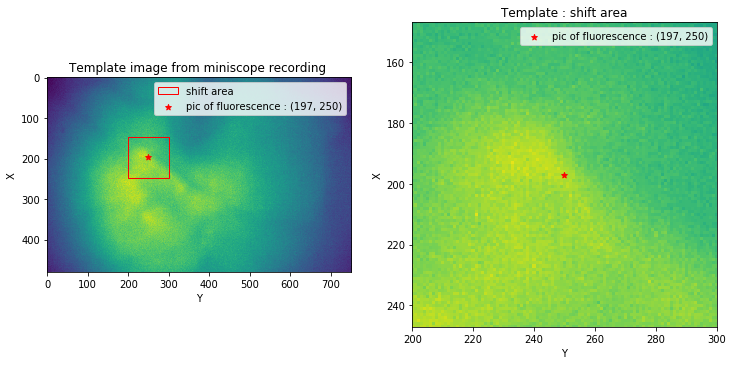

<Figure size 432x288 with 0 Axes>

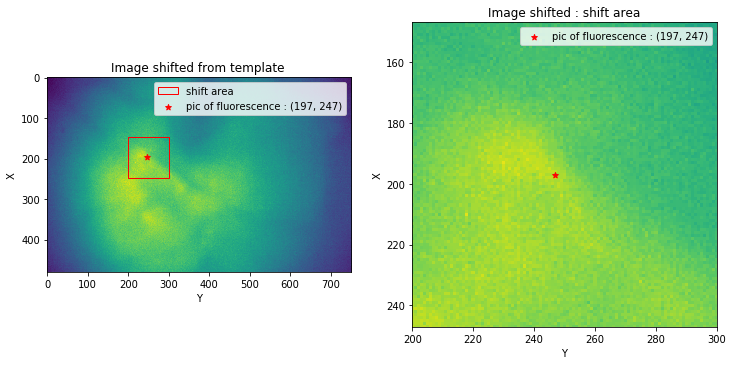

<Figure size 432x288 with 0 Axes>

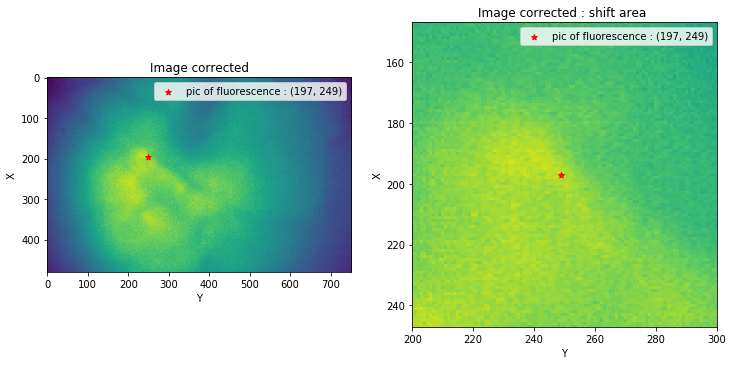

In [57]:
new_image = join_patches(image,max_shear,upsamp_wdims,new_overlaps,upsamp_pdims,upsamp_patches_index,patch_pos,total_shifts)
max_fluo_Nimage, mf_Nimage = get_max_fluo(new_image,parameters)


plt.figure()
fig2,(ax2,ax2z) = plt.subplots(1,2, figsize=(12,6))
ax2.imshow(template)
ax2.add_patch(copy(rect))
ax2.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r',label = "pic of fluorescence : " + str(max_fluo_template))
ax2.set_title('Template image from miniscope recording ')
ax2.set_xlabel('Y')
ax2.set_ylabel('X')
ax2.legend(loc='best')

ax2z.imshow(template)
ax2z.scatter(max_fluo_template[1], max_fluo_template[0], marker ='*', color='r',label = "pic of fluorescence : " + str(max_fluo_template))
ax2z.set_title('Template : shift area')
ax2z.set_xlabel('Y')
ax2z.set_ylabel('X')
ax2z.set_xlim(left,right)
ax2z.set_ylim(bottom,top)
ax2z.legend(loc='best')
plt.show()


plt.figure()
fig3,(ax3,ax3z)= plt.subplots(1,2, figsize=(12,6))
ax3.imshow(image)
ax3.add_patch(copy(rect))
ax3.scatter(max_fluo_image[1], max_fluo_image[0], marker ='*', color='r',label = "pic of fluorescence : " + str(max_fluo_image))
ax3.set_title('Image shifted from template ')
ax3.set_xlabel('Y')
ax3.set_ylabel('X')
ax3.legend(loc='best')

ax3z.imshow(image)
ax3z.scatter(max_fluo_image[1], max_fluo_image[0], marker ='*', color='r',label = "pic of fluorescence : " + str(max_fluo_image))
ax3z.set_title('Image shifted : shift area')
ax3z.set_xlabel('Y')
ax3z.set_ylabel('X')
ax3z.set_xlim(left,right)
ax3z.set_ylim(bottom,top)
ax3z.legend(loc='best')
plt.show()

plt.figure()
fig7, (ax7,ax7z) = plt.subplots(1,2, figsize=(12,6))
ax7.imshow(new_image)
ax7.scatter(max_fluo_Nimage[1], max_fluo_Nimage[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_Nimage))
ax7.set_title('Image corrected')
ax7.set_xlabel('Y')
ax7.set_ylabel('X')
ax7.legend(loc='best')

ax7z.imshow(new_image)
ax7z.scatter(max_fluo_Nimage[1], max_fluo_Nimage[0], marker ='*', color='r', label = "pic of fluorescence : " + str(max_fluo_Nimage))
ax7z.set_title('Image corrected : shift area ')
ax7z.set_xlabel('Y')
ax7z.set_ylabel('X')
ax7z.set_xlim(left,right)
ax7z.set_ylim(bottom,top)
ax7z.legend(loc='best')


plt.show()

If you want to see a complet example of NormCorre algorithme with the global and the piecwise correction see motion_correction.py
